# Alternative Models: Eager Learners I

<hr>

* Logistic Regression
* Decision Trees

In [1]:
# Import needed libraries and modules
from codecarbon import EmissionsTracker
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import optuna
from optuna.samplers import GPSampler
from sklearn.pipeline import Pipeline
import json

# Fetch dataset from UCI Repository
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original

In [2]:
# ---------------------------------------------------------------------------- #
#                                PRE-PROCESSING                                #
# ---------------------------------------------------------------------------- #

##### SETTINGS #####
PC_Features = True
Random_Seed = 82024
K_Folds = 10
Max_Iterations = 200
####################

# Drop missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Binarize target
df.loc[df['num'] != 0, 'num'] = 1

# Define features and target vectors
X = df.iloc[:,:-1]
y = df['num']

# Separate integer from categorical features
int_features, cat_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],\
['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('int', StandardScaler(), int_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

<hr>

## Logistic Regression:

In [3]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Initiate CodeCarbon to track emissions
tracker = EmissionsTracker('LR model', log_level='warning')
tracker.start()

# Create model
model = LogisticRegression(random_state=Random_Seed)

# Define pipeline depending on whether PCA is requested or not
if PC_Features:
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=12)),
        ('LR-classifier', model)
    ]
else:
    steps = [
        ('preprocessor', preprocessor),
        ('LR-classifier', model)
    ]
    
pipeline = Pipeline(steps)

# Perform cross-validation
cv_results = cross_validate(pipeline, X, y, scoring=['accuracy', 'roc_auc'], cv=K_Folds)

# Calculate and display results
acc = np.mean(cv_results['test_accuracy'])
acc_std = np.std(cv_results['test_accuracy'])
roc_auc = np.mean(cv_results['test_roc_auc'])
roc_auc_std = np.std(cv_results['test_roc_auc'])

print(f"Accuracy: {acc:.4f} ± {acc_std:.4f}")
print(f"AUC-ROC: {roc_auc:.4f} ± {roc_auc_std:.4f}")

# Stop emission tracking
_ = tracker.stop()

[codecarbon ERROR @ 10:26:57] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.


[codecarbon WARNING @ 10:26:57] Another instance of codecarbon is already running. Exiting.
[codecarbon WARNING @ 10:26:57] Another instance of codecarbon is already running. Exiting.


Accuracy: 0.8448 ± 0.0512
AUC-ROC: 0.9143 ± 0.0337


In [4]:
# Save evaluation to an external file
file = 'scores.csv'

results = pd.DataFrame({
    'LR-model': [acc, acc_std, roc_auc, roc_auc_std]
}, index = ['Accuracy', 'Accuracy STD', 'AUC-ROC', 'AUC-ROC STD'])

# Check if file exists
if os.path.exists(file):
    temp = pd.read_csv(file, index_col=0)
    results = pd.concat([temp, results], axis=1)

# Export
results.to_csv(file)

In [5]:
# ---------------------------------------------------------------------------- #
#                                 OPTIMIZATION                                 #
# ---------------------------------------------------------------------------- #

# Initiate CodeCarbon to track emissions
tracker = EmissionsTracker('LR optimization', log_level='warning')
tracker.start()

# Objective function
def objective(trial):
    # Define parameters
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)  # Parâmetro de regularização
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])  # Solver

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    penalty = 'l2' if solver != 'liblinear' else penalty

    # Create model
    temp_model = LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=1000)

    # Define pipeline depending on whether PCA is requested or not
    if PC_Features:
        steps = [
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=12)),
            ('LR-classifier', temp_model)
        ]
    else:
        steps = [
            ('preprocessor', preprocessor),
            ('LR-classifier', temp_model)
        ]
        
    pipeline = Pipeline(steps)
    
    # Perform cross-validation
    roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=K_Folds).mean()
    
    return roc_auc


# Optimizing with Optuna
study = optuna.create_study(direction='maximize', sampler=GPSampler())
study.optimize(objective, n_trials=100)

[codecarbon ERROR @ 10:26:57] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.
[codecarbon WARNING @ 10:26:57] Another instance of codecarbon is already running. Exiting.
/tmp/ipykernel_118705/2460874507.py:43: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study = optuna.create_study(direction='maximize', sampler=GPSampler())
[I 2024-10-31 10:26:59,026] A new study created in memory with name: no-name-541c023a-a261-4788-8b23-5efc32efdbbd
[I 2024-10-31 10:26:59,185] Trial 0 finished with value: 0.8866414835164835 and parameters: {'C': 0.0009186799213595288, 'solver': 'saga', 'penalty': 'l2'}. Best is trial 0 with value: 0.8866414835164835.
[I 2024-10-31 10:26:59,323] Trial 1 finished with value: 0.9160027472527472 and parameters: {'C': 10.436991137523872, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 1 with value: 0.9160027472527472.
[I 2

In [6]:
# Show best model
trial = study.best_trial
print('AUC-ROC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

# Save best trial parameters to a JSON file
with open('params/LR-params.json', 'w') as f:
    json.dump(trial.params, f)

AUC-ROC: 0.9207417582417582
Best hyperparameters: {'C': 0.3454523724514798, 'solver': 'liblinear', 'penalty': 'l1'}


In [7]:
# Visualizing optimization
optuna.visualization.plot_optimization_history(study)

In [8]:
optuna.visualization.plot_slice(study)

In [9]:
# Create optimized model
best_params = trial.params
model = LogisticRegression(random_state=Random_Seed, **best_params)

# Define pipeline depending on whether PCA is requested or not
if PC_Features:
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=12)),
        ('LR-classifier', model)
    ]
else:
    steps = [
        ('preprocessor', preprocessor),
        ('LR-classifier', model)
    ]
    
pipeline = Pipeline(steps)

# Perform cross-validation
cv_results = cross_validate(pipeline, X, y, scoring=['accuracy', 'roc_auc'], cv=K_Folds)

# Calculate and display results
acc = np.mean(cv_results['test_accuracy'])
acc_std = np.std(cv_results['test_accuracy'])
roc_auc = np.mean(cv_results['test_roc_auc'])
roc_auc_std = np.std(cv_results['test_roc_auc'])

print(f"Accuracy: {acc:.4f} ± {acc_std:.4f}")
print(f"AUC-ROC: {roc_auc:.4f} ± {roc_auc_std:.4f}")

# Stop emission tracking
_ = tracker.stop()

[codecarbon WARNING @ 10:27:38] Another instance of codecarbon is already running. Exiting.


Accuracy: 0.8549 ± 0.0530
AUC-ROC: 0.9207 ± 0.0319


In [10]:
# Save evaluation to an external file
file = 'scores.csv'

results = pd.DataFrame({
    'LR-optimization': [acc, acc_std, roc_auc, roc_auc_std]
}, index = ['Accuracy', 'Accuracy STD', 'AUC-ROC', 'AUC-ROC STD'])

# Check if file exists
if os.path.exists(file):
    temp = pd.read_csv(file, index_col=0)
    results = pd.concat([temp, results], axis=1)

# Export
results.to_csv(file)

<hr>

## Decision Tree:

In [11]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Initiate CodeCarbon to track emissions
tracker = EmissionsTracker('DT model', log_level='warning')
tracker.start()

# Create model
model = tree.DecisionTreeClassifier(random_state=Random_Seed)

# Define pipeline depending on whether PCA is requested or not
if PC_Features:
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=12)),
        ('DT-classifier', model)
    ]
else:
    steps = [
        ('preprocessor', preprocessor),
        ('DT-classifier', model)
    ]
    
pipeline = Pipeline(steps)

# Perform cross-validation
cv_results = cross_validate(pipeline, X, y, scoring=['accuracy', 'roc_auc'], cv=K_Folds)

# Calculate and display results
acc = np.mean(cv_results['test_accuracy'])
acc_std = np.std(cv_results['test_accuracy'])
roc_auc = np.mean(cv_results['test_roc_auc'])
roc_auc_std = np.std(cv_results['test_roc_auc'])

print(f"Accuracy: {acc:.4f} ± {acc_std:.4f}")
print(f"AUC-ROC: {roc_auc:.4f} ± {roc_auc_std:.4f}")

# Stop emission tracking
_ = tracker.stop()

[codecarbon ERROR @ 10:27:38] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.
[codecarbon WARNING @ 10:27:38] Another instance of codecarbon is already running. Exiting.


[codecarbon WARNING @ 10:27:38] Another instance of codecarbon is already running. Exiting.


Accuracy: 0.7572 ± 0.0554
AUC-ROC: 0.7552 ± 0.0592


In [12]:
# Save evaluation to an external file
file = 'scores.csv'

results = pd.DataFrame({
    'DT-model': [acc, acc_std, roc_auc, roc_auc_std]
}, index = ['Accuracy', 'Accuracy STD', 'AUC-ROC', 'AUC-ROC STD'])

# Check if file exists
if os.path.exists(file):
    temp = pd.read_csv(file, index_col=0)
    results = pd.concat([temp, results], axis=1)

# Export
results.to_csv(file)

In [13]:
# ---------------------------------------------------------------------------- #
#                                 OPTIMIZATION                                 #
# ---------------------------------------------------------------------------- #

# Initiate CodeCarbon to track emissions
tracker = EmissionsTracker('DT optimization', log_level='warning')
tracker.start()

# Objective function
def objective(trial):
    # Define parameters
    max_depth = int(trial.suggest_int('max_depth', 1, 32))  # Faixa para max_depth
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Faixa para min_samples_split
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)  # Faixa para min_samples_leaf
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])  # Critério de divisão

    # Create model
    temp_model = tree.DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion
    )
    
    # Define pipeline depending on whether PCA is requested or not
    if PC_Features:
        steps = [
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=12)),
            ('DT-classifier', temp_model)
        ]
    else:
        steps = [
            ('preprocessor', preprocessor),
            ('DT-classifier', temp_model)
        ]
        
    pipeline = Pipeline(steps)
    
    # Perform cross-validation
    roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=K_Folds).mean()
    
    return roc_auc
    
# Optimizing with Optuna
study = optuna.create_study(direction='maximize', sampler=GPSampler())
study.optimize(objective, n_trials=100)

[codecarbon ERROR @ 10:27:38] Error: Another instance of codecarbon is already running. Turn off the other instance to be able to run this one. Exiting.
[codecarbon WARNING @ 10:27:38] Another instance of codecarbon is already running. Exiting.
/tmp/ipykernel_118705/2681190905.py:46: ExperimentalWarning:

GPSampler is experimental (supported from v3.6.0). The interface can change in the future.

[I 2024-10-31 10:27:38,277] A new study created in memory with name: no-name-cccd6cd0-4df7-4297-bf60-93e2020a0c8d
[I 2024-10-31 10:27:38,419] Trial 0 finished with value: 0.8274896978021978 and parameters: {'max_depth': 25, 'min_samples_split': 14, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.8274896978021978.
[I 2024-10-31 10:27:38,586] Trial 1 finished with value: 0.8380837912087913 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8380837912087913.
[I 2024-10-31 10:27:38,717]

In [14]:
# Show best model
trial = study.best_trial
print('AUC-ROC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

# Save best trial parameters to a JSON file
with open('params/DT-params.json', 'w') as f:
    json.dump(trial.params, f)

AUC-ROC: 0.8512877747252746
Best hyperparameters: {'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 2, 'criterion': 'gini'}


In [15]:
# Visualizing optimization
optuna.visualization.plot_optimization_history(study)

In [16]:
optuna.visualization.plot_slice(study)

[codecarbon WARNING @ 10:28:16] Another instance of codecarbon is already running. Exiting.


Accuracy: 0.7941 ± 0.0685
AUC-ROC: 0.8526 ± 0.0577


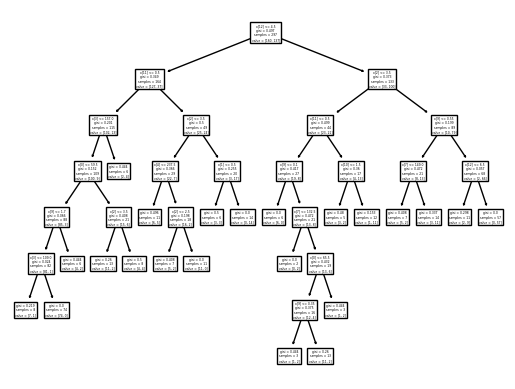

In [17]:
# Create optimized model
best_params = trial.params
model = tree.DecisionTreeClassifier(random_state=Random_Seed, **best_params)

# Define pipeline depending on whether PCA is requested or not
if PC_Features:
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=12)),
        ('DT-classifier', model)
    ]
else:
    steps = [
        ('preprocessor', preprocessor),
        ('DT-classifier', model)
    ]
    
pipeline = Pipeline(steps)

# Perform cross-validation
cv_results = cross_validate(pipeline, X, y, scoring=['accuracy', 'roc_auc'], cv=K_Folds)

# Calculate and display results
acc = np.mean(cv_results['test_accuracy'])
acc_std = np.std(cv_results['test_accuracy'])
roc_auc = np.mean(cv_results['test_roc_auc'])
roc_auc_std = np.std(cv_results['test_roc_auc'])

print(f"Accuracy: {acc:.4f} ± {acc_std:.4f}")
print(f"AUC-ROC: {roc_auc:.4f} ± {roc_auc_std:.4f}")

# Plot decision tree
preprocessor.fit_transform(X)
PCA(n_components=12).fit_transform(X)
model.fit(X, y)
plot = tree.plot_tree(model)

# Stop emission tracking
_ = tracker.stop()


In [18]:
# Save evaluation to an external file
file = 'scores.csv'

results = pd.DataFrame({
    'DT-optimization': [acc, acc_std, roc_auc, roc_auc_std]
}, index = ['Accuracy', 'Accuracy STD', 'AUC-ROC', 'AUC-ROC STD'])

# Check if file exists
if os.path.exists(file):
    temp = pd.read_csv(file, index_col=0)
    results = pd.concat([temp, results], axis=1)

# Export
results.to_csv(file)

### References:
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
* https://scikit-learn.org/stable/modules/tree.html